In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet201, VGG16, VGG19, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import HeUniform

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve

import sklearn
from sklearn.model_selection import train_test_split
import os
import numpy as np
import os
import shutil
import random
from matplotlib import pyplot as plt
import matplotlib

print("\nLibraries\n-----------------------------")
print(f"Tensorflow: {tf.__version__}")
print(f"Scikit Learn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")


Libraries
-----------------------------
Tensorflow: 2.12.0
Scikit Learn: 1.2.1
Numpy: 1.22.1
Matplotlib: 3.7.0


In [2]:
def count_files_in_directory(directory_path):
    total_files = 0

    for root, _, files in os.walk(directory_path):
        total_files += len(files)

    return total_files

In [3]:
def create_test_set(source_dir, test_dir, class_names, test_percent):
    os.makedirs(test_dir, exist_ok = True)
    
    for class_name in class_names:
        class_source_dir = os.path.join(source_dir, class_name)
        class_test_dir = os.path.join(test_dir, class_name)
        os.makedirs(class_test_dir, exist_ok = True)
        
        images = os.listdir(class_source_dir)
        num_images = len(images)
        num_test_images = int(test_percent * num_images)
        
        test_indices = random.sample(range(num_images), num_test_images)
        
        for index in test_indices:
            image_name = images[index]
            source_path = os.path.join(class_source_dir, image_name)
            target_path = os.path.join(class_test_dir, image_name)
            shutil.move(source_path, target_path)

In [4]:
# Define image dimensions and other parameters
img_height, img_width = 80, 400

data_dir = "./DS1"

# test set
train_data_dir = "./DS1/Train"
test_data_dir = "./DS1/Test"
valid_data_dir = "./DS1/Valid"

class_names = os.listdir(train_data_dir)

first_execution = True

if first_execution:
    create_test_set(train_data_dir, test_data_dir, class_names, 0.3)
    create_test_set(train_data_dir, valid_data_dir, class_names, 0.2)

In [5]:
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1.0 / 255.0,
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input
)

data_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = 32,
    class_mode = 'binary',
    shuffle = True
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_datagen.flow_from_directory(
        valid_data_dir,
        target_size = (img_height, img_width),
        batch_size = 14,
        class_mode = 'binary',
        shuffle = True
)

Found 302 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [6]:
base_model = ResNet50(
    weights = "imagenet",
    include_top = False,
    input_shape = (img_height, img_width, 3)
)

# freeze already trained layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation = 'relu', kernel_initializer = 'uniform')(x)
predictions = Dense(1, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 400, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 86, 406, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 40, 200, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 40, 200, 64)  256         ['conv1_conv[0][0]']         

 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 20, 100, 64)  0          ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 20, 100, 64)  36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 20, 100, 64)  256        ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block3_1_bn (BatchNormal  (None, 10, 50, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 10, 50, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 10, 50, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 10, 50, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 5, 25, 256)  1024        ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 5, 25, 256)  0           ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 5, 25, 256)   590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 5, 25, 256)  1024        ['conv4_block2_2_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 5, 25, 256)   590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 5, 25, 256)  1024        ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 5, 25, 256)  0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 3, 13, 512)   2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 3, 13, 512)  2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 3, 13, 512)  0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

In [8]:
model.compile(optimizer = SGD(learning_rate = 0.001, momentum = 0.9),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(data_generator, epochs = 100,
                    validation_data = validation_generator, verbose = 0)

### Please note that while the loss curve is ideal, the accuracy curve is a clear example of an algorithm that is not learning anything. The fact that neither validation nor training accuracy changes at any point through time is a clear indication that the algorithm isn't really learning anything at all, i.e. the train and validation sets are insufficient for the task

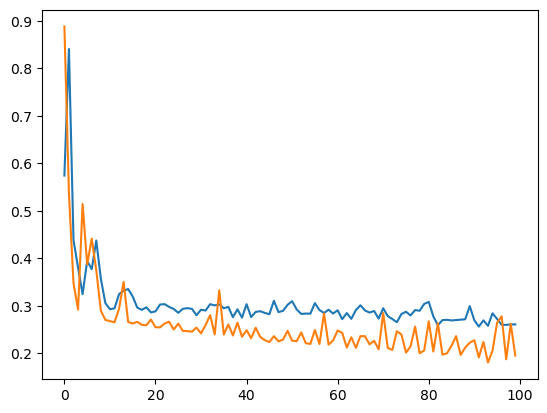

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

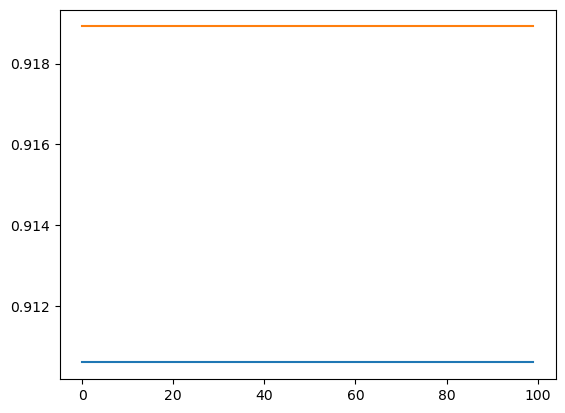

In [10]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [11]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    class_mode = 'binary',
    batch_size = count_files_in_directory(test_data_dir),
    shuffle = False
)

Found 159 images belonging to 2 classes.


In [12]:
real_labels = []
test_probs = []
test_labels = []
batch_images, batch_labels = next(test_generator)

for individual_image in range(batch_images.shape[0]):
    single_image_array = batch_images[individual_image]
    single_image_label = batch_labels[individual_image]
    
    test_prob = model.predict(np.expand_dims(single_image_array, axis=0), verbose = 0)
    test_pred = np.argmax(test_prob)
    
    real_labels.append(single_image_label)
    test_probs.append(test_prob[0, test_pred])
    test_labels.append(test_pred)

test_probs = np.array(test_probs).reshape(-1)
test_labels = np.array(test_labels).reshape(-1)

### Please note through both loss values and the confusion matrix that the algorithm basically classes everything as a cut mark, regardless of whether it is or it isnt, this is a clear sign of an algorithm that is not working. This is due to the large imbalance between the two classes in the dataset

In [13]:
indices0 = [index for index, value in enumerate(real_labels) if value == 0]
indices1 = [index for index, value in enumerate(real_labels) if value == 1]
test_croc_probs = 1 - test_probs[indices0]
test_cm_probs = test_probs[indices1]

print(f"Crocodile Loss {np.sqrt(np.mean(np.square(1 - test_croc_probs))) * 100:.2f}%")
print(f"Cut Mark Loss {np.sqrt(np.mean(np.square(1 - test_cm_probs))) * 100:.2f}%")
print(f"Overall Loss {np.sqrt(np.mean(np.square(np.concatenate((1 - test_croc_probs, 1 - test_cm_probs))))) * 100:.2f}%")

Crocodile Loss 100.00%
Cut Mark Loss 0.00%
Overall Loss 28.59%


In [14]:
print(classification_report(real_labels, test_labels))
print(confusion_matrix(real_labels, test_labels))

              precision    recall  f1-score   support

         0.0       0.08      1.00      0.15        13
         1.0       0.00      0.00      0.00       146

    accuracy                           0.08       159
   macro avg       0.04      0.50      0.08       159
weighted avg       0.01      0.08      0.01       159

[[ 13   0]
 [146   0]]


C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [15]:
return_files = True

if return_files:
    source_folders = ["./DS1/Test", "./DS1/Valid"]
    destination_folder = "./DS1/Train"

    for source_folder in source_folders:
        croc_source_path = os.path.join(source_folder, "Crocodile")
        cut_mark_source_path = os.path.join(source_folder, "CutMark")

        croc_destination_path = os.path.join(destination_folder, "Crocodile")
        cut_mark_destination_path = os.path.join(destination_folder, "CutMark")

        for filename in os.listdir(croc_source_path):
            source_file = os.path.join(croc_source_path, filename)
            destination_file = os.path.join(croc_destination_path, filename)
            shutil.move(source_file, destination_file)

        for filename in os.listdir(cut_mark_source_path):
            source_file = os.path.join(cut_mark_source_path, filename)
            destination_file = os.path.join(cut_mark_destination_path, filename)
            shutil.move(source_file, destination_file)

    print("Files moved successfully.")

Files moved successfully.


In [16]:
import winsound
winsound.Beep(1000, 2000)  # Beep at 1000 Hz for 200 milliseconds